# Signal-to-noise Comparison

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import sys
from ipywidgets import interactive
import ipywidgets as widgets
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

%matplotlib inline
sns.set_context("talk")

## Reading the Fits file and getting the eigenvalues

In [2]:
thing = fits.open("../2pt_NG.fits")    # DES covariance matrix
covariance = np.loadtxt('2pt_covariance.txt', dtype=np.float64)

covmat = thing[1].data[0:400,0:400]    # Defining the covariance matrix
evals, evecs = np.linalg.eigh(covmat)  # Eigenvalues and eigenvectors of the covariance matrix

## Reading the parameter files output

In [3]:
tj = np.loadtxt('2pt_theory.txt', dtype=np.float64)

## Calculating the signal-to-noise ratio

## \begin{align}
\left( \frac{S}{N} \right)^2 &= \sum_{ij} T_i C^{-1}_{ij}T_j \\
& = \sum_{ij} \frac{v_i^2}{\lambda_i}
\end{align}

## \begin{equation}
v_i \equiv U_{ij}^T T_j
\end{equation}

### * $\lambda$: eigenvalues (evals)
### * $T$: theoretical values (tj)
### * $U$: eigenvectors (evecs)

## For $\xi_{+/-}$

In [12]:
v_i = (np.dot(evecs.T,tj))

v_i2 = (v_i)**2

sn_i = np.sqrt(v_i2/evals)

sn = sum(sn_i)

print("Signal-to-noise ratio for xi_pm =", round(sn,3))

Signal-to-noise ratio for xi_pm = 474.834


### Plots

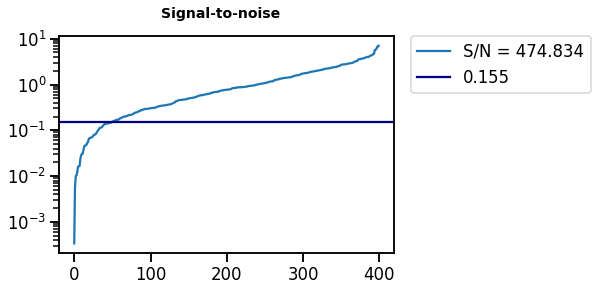

In [15]:
fig, ax = plt.subplots()

ax.set(yscale="log")

sns.lineplot(np.arange(0, 400), np.sort(sn_i), ax=ax, label="S/N = 474.834")

plt.axhline(np.sort(sn_i)[50], color="navy", label="0.155")

plt.suptitle('Signal-to-noise', fontsize=14, fontweight="bold")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('Plots/SN-xipm-lowest_values.png', dpi=400, bbox_inches='tight')

# Getting rid of the values with smallest signal-to-noise ratio

Set them to something a lot lower, like $10^{-8}$.

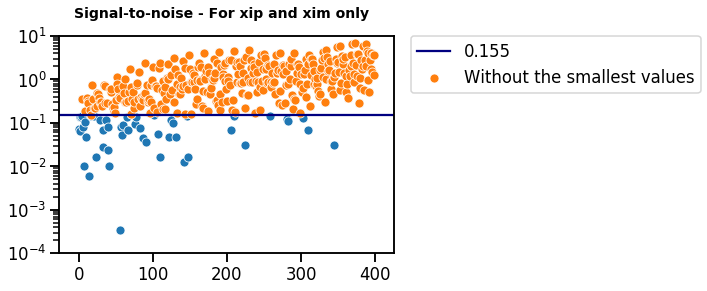

In [16]:
sn_i_remove_lowest = sn_i.copy()
sn_i_remove_lowest[sn_i_remove_lowest < np.sort(sn_i)[50]] = 1e-8


# ---   Plots   ---

fig, ax = plt.subplots()

ax.set(yscale="log")
plt.ylim(1e-4, 1e1)

sns.scatterplot(np.arange(0, 400), sn_i, ax=ax)

sns.scatterplot(np.arange(0, 400), sn_i_remove_lowest, ax=ax, label="Without the smallest values")

plt.axhline(0.15501231765449366, color="navy", label="0.155")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.suptitle('Signal-to-noise - For xip and xim only', fontsize=14, fontweight="bold")

plt.show()

### Getting back the original matrix and checking if it's all good

In [17]:
evals_remove_lowest = v_i2/(sn_i_remove_lowest**2)

covmat_remove_lowest = np.dot((evecs*evals_remove_lowest),np.linalg.inv(evecs))

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

print("Is the matrix positive definite?", is_pos_def(covmat_remove_lowest))

Is the matrix positive definite? True


In [66]:
#thing[1].data[0:400,0:400] = covmat_remove_lowest
#thing.writeto('2pt_SN-fixed.fits')

____________

# Cool interactive plots

In [18]:
layout = go.Layout(yaxis=dict(type='log',
                              title='eigenvalues',
                              ticks='outside',
                              exponentformat='power',
                              showexponent='all',
                              range=[-14,-9]),
                   xaxis=dict(showticklabels=True, showline=True),
                   title='<b>Removing the modes with lowest signal-to-noise</b>',
                   hovermode='closest')

original_CM = go.Scatter(
    x = np.arange(0, 400),
    y = evals[0:400],
    name = 'Original Covariance Matrix')

In [19]:
values = widgets.SelectMultiple(options=list(np.arange(2, 9)), 
                                value=(8, ),    # default value
                                description='$10^-$')

def update_plot(values):
    """
    This function updates the plot everytime a widget is changed
    """
    
    data = []
    
    for magnitude in values:
        sn_i_remove_lowest = sn_i.copy()
        sn_i_remove_lowest[sn_i_remove_lowest < np.sort(sn_i)[50]] = 1*10**float(-magnitude)
        evals_remove_lowest = v_i2/(sn_i_remove_lowest**2)
        unsorted = go.Scatter(x=np.arange(0, 400),
                           y=evals_remove_lowest[0:400],
                           name = 'Unsorted modified eigenvalues')
        data.append(unsorted)
        
    fig3 = go.Figure(data=[original_CM, unsorted], layout=layout)
    
    fig3.add_scatter(mode='lines')
    
    iplot(fig3)
    
widgets.interactive(update_plot, values=values)

interactive(children=(SelectMultiple(description='$10^-$', index=(6,), options=(2, 3, 4, 5, 6, 7, 8), value=(8…

## Check how this compares to removing the highest eigenvalues

In [20]:
evals_2 = evals.copy()
evals_2[350:400] = 1

# ---- Obtaining new Covariance Matrix with the new Eigenvalues ----

covmat2 = np.dot((evecs*evals_2),np.linalg.inv(evecs))
evals2, evecs2 = np.linalg.eigh(covmat2)

Text(0.5, 0.98, 'Comparing the new eigenvalues')

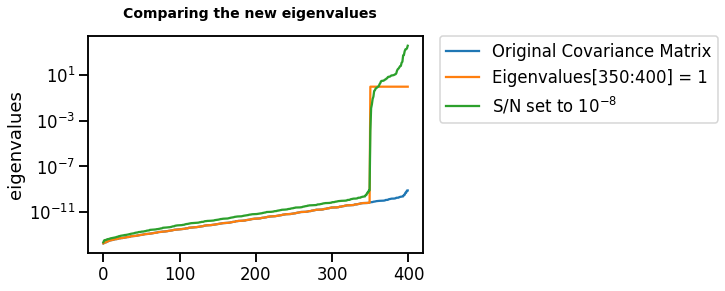

In [21]:
fig, ax = plt.subplots()

ax.set(yscale="log",
      ylabel="eigenvalues")

sns.lineplot(np.arange(0, 400), evals, ax=ax, label="Original Covariance Matrix")

sns.lineplot(np.arange(0, 400), evals2, ax=ax, label="Eigenvalues[350:400] = 1")

sns.lineplot(np.arange(0, 400), np.sort(evals_remove_lowest[0:400]), ax=ax, label="S/N set to $10^{-8}$")

#plt.ylim(1e-14, 1e-9)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.suptitle('Comparing the new eigenvalues', fontsize=14, fontweight="bold")

#plt.savefig('Plots/Comparing-zoom.png', dpi=400, bbox_inches='tight')